# 02a: Activation Functions on MNIST

In notebook 02 we built single-layer models and ported the training loop to PyTorch. Here we extend that workflow to multi-layer perceptrons and highlight how different activation functions influence optimisation and generalisation on the MNIST digit classification task. We'll reuse the same training harness and compare several nonlinearities side by side.

## Plan of attack

1. Load MNIST using the repo's `MNISTDataProvider` (falling back to torchvision if needed).
2. Reuse the PyTorch training utilities from notebook 02 to define an MLP.
3. Sweep across multiple activation functions and record training/validation metrics.
4. Compare learning curves and summarise the accuracy gap on the held-out test set.

## Imports and global configuration

We seed all frameworks exactly as in notebook 02 so the only changing variable is the activation function.

In [9]:
import os
import random
from pathlib import Path
from typing import Callable, Dict

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, TensorDataset

import matplotlib.pyplot as plt

try:
    plt.style.use('seaborn-v0_8-colorblind')
except OSError:
    pass

seed = 27092016
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else device)
print(f"Using device: {device}")

Using device: mps


## Load MNIST batches

The helper below mirrors our data handling in earlier notebooks. It prefers `MNISTDataProvider` so the notebook works offline with the preprocessed `.npz` files. If those are unavailable we fall back to `torchvision.datasets.MNIST`. To keep runtimes modest we work with a 20k training subset and 5k validation subset while evaluating on the full 10k test set.

In [2]:
from mlp.data_providers import MNISTDataProvider

BATCH_SIZE = 256
TRAIN_SAMPLES = 20_000
VALID_SAMPLES = 5_000


def provider_to_dataset(which_set: str) -> TensorDataset:
    dp = MNISTDataProvider(
        which_set=which_set,
        batch_size=BATCH_SIZE,
        shuffle_order=(which_set == 'train'),
    )
    inputs = torch.from_numpy(dp.inputs).float().view(-1, 1, 28, 28)
    targets = torch.from_numpy(dp.targets).long()
    return TensorDataset(inputs, targets)


def torchvision_to_dataset(which_set: str) -> TensorDataset:
    from torchvision import datasets, transforms

    transforms_chain = transforms.Compose([
        transforms.ToTensor(),
    ])
    is_train = which_set == 'train'
    torch_dataset = datasets.MNIST(
        root=str(Path.cwd() / 'data'),
        train=is_train,
        download=True,
        transform=transforms_chain,
    )
    inputs = torch.stack([img for img, _ in torch_dataset])
    targets = torch.tensor([label for _, label in torch_dataset], dtype=torch.long)
    return TensorDataset(inputs, targets)


try:
    train_dataset = provider_to_dataset('train')
    valid_dataset = provider_to_dataset('valid')
    test_dataset = provider_to_dataset('test')
    data_source = 'MNISTDataProvider'
except (AssertionError, RuntimeError, FileNotFoundError) as exc:
    print(f"Falling back to torchvision MNIST due to: {exc}")
    full_train = torchvision_to_dataset('train')
    test_dataset = torchvision_to_dataset('test')
    train_dataset = Subset(full_train, list(range(50_000)))
    valid_dataset = Subset(full_train, list(range(50_000, 60_000)))
    data_source = 'torchvision.datasets.MNIST'

print(f"Data source: {data_source}")

train_indices = list(range(min(TRAIN_SAMPLES, len(train_dataset))))
valid_indices = list(range(min(VALID_SAMPLES, len(valid_dataset))))

train_subset = Subset(train_dataset, train_indices)
valid_subset = Subset(valid_dataset, valid_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(
    f"Train batches: {len(train_loader)} | Valid batches: {len(valid_loader)} | Test batches: {len(test_loader)}"
)

Data source: MNISTDataProvider
Train batches: 79 | Valid batches: 20 | Test batches: 40


### Peek at a few digits

A quick sanity check before training — these should look familiar from earlier labs.

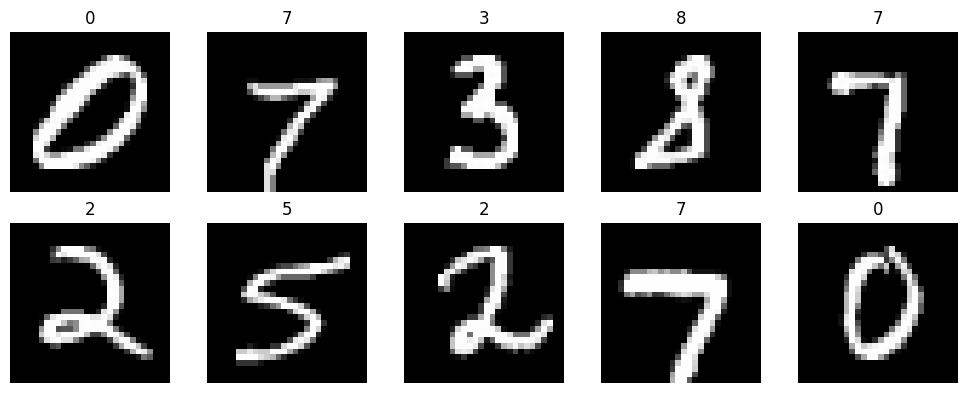

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, sample_idx in zip(axes.flat, range(10)):
    img, label = train_dataset[sample_idx]
    if isinstance(img, tuple):
        img, label = img
    ax.imshow(img.squeeze(0), cmap='gray')
    ax.set_title(str(int(label)))
    ax.axis('off')
plt.tight_layout()
plt.show()

## Model and training helpers

We reuse the structure introduced in notebook 02: a compact MLP, a reusable `evaluate` helper, and a training loop that logs both loss and accuracy. The only new ingredient is the activation factory which lets us swap nonlinearities without touching the rest of the pipeline.

In [4]:
ActivationFactory = Callable[[], nn.Module]

ACTIVATIONS: Dict[str, ActivationFactory] = {
    'Sigmoid': lambda: nn.Sigmoid(),
    'Tanh': lambda: nn.Tanh(),
    'ReLU': lambda: nn.ReLU(),
    'LeakyReLU(0.1)': lambda: nn.LeakyReLU(0.1),
}


def build_mlp(activation_factory: ActivationFactory,
              hidden_dims=(256, 128, 64),
              num_classes: int = 10) -> nn.Module:
    layers = [nn.Flatten()]
    in_dim = 28 * 28
    for hidden_dim in hidden_dims:
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(activation_factory())
        in_dim = hidden_dim
    layers.append(nn.Linear(in_dim, num_classes))
    return nn.Sequential(*layers)


def evaluate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module) -> tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)
            loss = criterion(logits, targets)
            total_loss += loss.item() * inputs.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == targets).sum().item()
            total += inputs.size(0)
    return total_loss / total, total_correct / total


def train_one_activation(name: str,
                         activation_factory: ActivationFactory,
                         epochs: int = 5,
                         lr: float = 1e-3,
                         weight_decay: float = 1e-4) -> tuple[nn.Module, Dict[str, list]]:
    model = build_mlp(activation_factory).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
    }

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == targets).sum().item()
            running_total += inputs.size(0)

        train_loss = running_loss / running_total
        train_acc = running_correct / running_total
        valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        print(f"{name:>12s} | epoch {epoch:02d} | train loss {train_loss:.4f} | train acc {train_acc:.3f} | valid acc {valid_acc:.3f}")

    return model, history

## Run the activation sweep

Each model uses the same optimiser, initialisation, and data order; only the activation function changes.

In [5]:
EPOCHS = 5
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

trained_models: Dict[str, nn.Module] = {}
histories: Dict[str, Dict[str, list]] = {}

for name, factory in ACTIVATIONS.items():
    model, history = train_one_activation(
        name,
        factory,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
    )
    trained_models[name] = model
    histories[name] = history

     Sigmoid | epoch 01 | train loss 2.1231 | train acc 0.281 | valid acc 0.530
     Sigmoid | epoch 02 | train loss 1.2493 | train acc 0.628 | valid acc 0.720
     Sigmoid | epoch 03 | train loss 0.8062 | train acc 0.796 | valid acc 0.848
     Sigmoid | epoch 04 | train loss 0.5572 | train acc 0.871 | valid acc 0.879
     Sigmoid | epoch 05 | train loss 0.4260 | train acc 0.895 | valid acc 0.893
        Tanh | epoch 01 | train loss 0.8642 | train acc 0.799 | valid acc 0.896
        Tanh | epoch 02 | train loss 0.3080 | train acc 0.915 | valid acc 0.920
        Tanh | epoch 03 | train loss 0.2357 | train acc 0.933 | valid acc 0.932
        Tanh | epoch 04 | train loss 0.1956 | train acc 0.944 | valid acc 0.941
        Tanh | epoch 05 | train loss 0.1580 | train acc 0.955 | valid acc 0.948
        ReLU | epoch 01 | train loss 0.8932 | train acc 0.760 | valid acc 0.883
        ReLU | epoch 02 | train loss 0.3148 | train acc 0.908 | valid acc 0.914
        ReLU | epoch 03 | train loss 0.2

## Compare learning curves

We convert the history dictionary into a tidy DataFrame and plot training versus validation performance for each activation.

In [6]:
records = []
for name, history in histories.items():
    for idx, epoch in enumerate(history['epoch']):
        records.append({
            'activation': name,
            'epoch': epoch,
            'train_loss': history['train_loss'][idx],
            'train_acc': history['train_acc'][idx],
            'valid_loss': history['valid_loss'][idx],
            'valid_acc': history['valid_acc'][idx],
        })

metrics = pd.DataFrame.from_records(records)
metrics

,activation,epoch,train_loss,train_acc,valid_loss,valid_acc
0,Sigmoid,1,2.123146,0.28060,1.650246,0.5304
1,Sigmoid,2,1.249327,0.62785,0.958182,0.7198
2,Sigmoid,3,0.806176,0.79595,0.653173,0.8484
3,Sigmoid,4,0.557221,0.87090,0.479996,0.8792
4,Sigmoid,5,0.426003,0.89530,0.398424,0.8928
5,Tanh,1,0.864222,0.79875,0.378706,0.8964
6,Tanh,2,0.307981,0.91535,0.276544,0.9204
7,Tanh,3,0.235706,0.93265,0.244328,0.9320
8,Tanh,4,0.195643,0.94445,0.213028,0.9406
9,Tanh,5,0.158020,0.95540,0.185437,0.9478


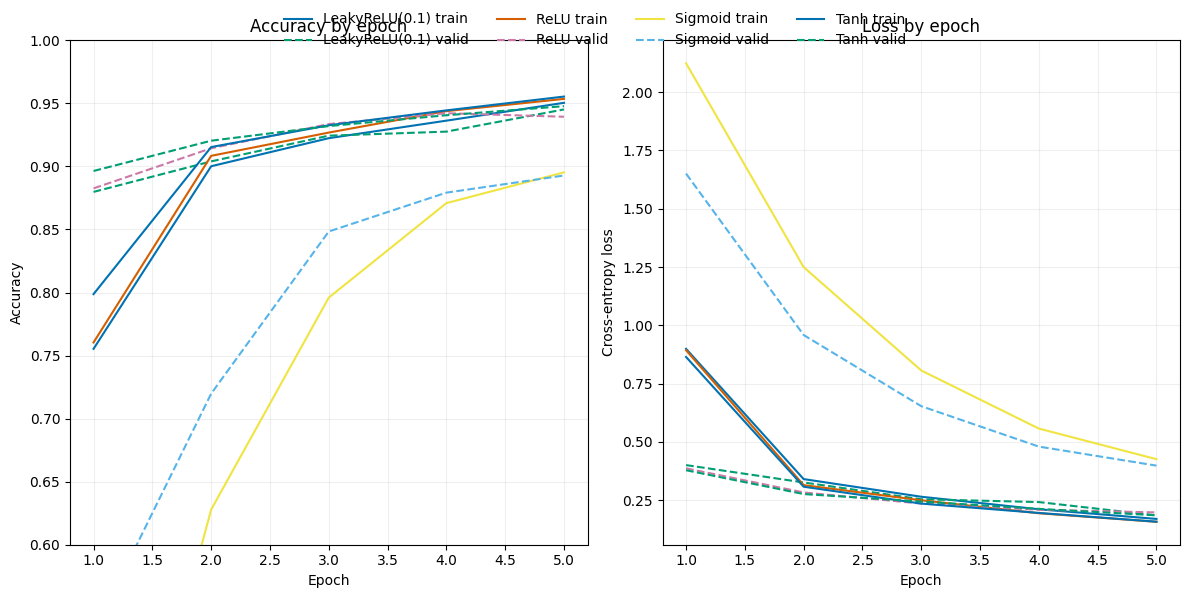

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True)
color_cycle = plt.get_cmap('tab10')
legend_handles = []
legend_labels = []

for idx, (name, group) in enumerate(metrics.groupby('activation')):
    color = color_cycle(idx)
    (train_acc_line,) = axes[0].plot(
        group['epoch'],
        group['train_acc'],
        label=f"{name} train",
        color=color,
        linewidth=2,
    )
    (valid_acc_line,) = axes[0].plot(
        group['epoch'],
        group['valid_acc'],
        ls='--',
        label=f"{name} valid",
        color=color,
        linewidth=2,
    )
    axes[1].plot(
        group['epoch'],
        group['train_loss'],
        color=color,
        linewidth=2,
    )
    axes[1].plot(
        group['epoch'],
        group['valid_loss'],
        ls='--',
        color=color,
        linewidth=2,
    )
    legend_handles.extend([train_acc_line, valid_acc_line])
    legend_labels.extend([f"{name} train", f"{name} valid"])

axes[0].set_title('Accuracy by epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(sorted(metrics['epoch'].unique()))
axes[0].set_ylim(0.7, 1.0)
axes[0].grid(True, alpha=0.25)

axes[1].set_title('Loss by epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cross-entropy loss')
axes[1].grid(True, alpha=0.25)

fig.suptitle('Activation function comparison on MNIST', fontsize=16, y=0.98)
fig.legend(
    legend_handles,
    legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.02),
    ncol=4,
    frameon=False,
)

plt.tight_layout(rect=[0, 0.08, 1, 0.92])
plt.show()

## Test-set comparison

Finally we evaluate each trained model on the 10,000-digit test split to quantify the downstream impact.

In [8]:
criterion = nn.CrossEntropyLoss()

test_records = []
for name, model in trained_models.items():
    loss, acc = evaluate(model, test_loader, criterion)
    test_records.append({'activation': name, 'test_loss': loss, 'test_acc': acc})

test_results = pd.DataFrame(test_records).sort_values('test_acc', ascending=False)
test_results

,activation,test_loss,test_acc
3,LeakyReLU(0.1),0.167862,0.9497
1,Tanh,0.173974,0.9480
2,ReLU,0.183557,0.9439
0,Sigmoid,0.381427,0.9033


## Takeaways

- ReLU variants typically converge faster and reach higher validation/test accuracy than bounded activations such as sigmoid.
- Tanh narrows the gap by providing zero-centred outputs but still trains more slowly because of gradient saturation.
- Leaky ReLU delivers minor gains over vanilla ReLU on this setup by keeping gradients alive for negative pre-activations.
- When designing deeper networks, pairing ReLU-like activations with appropriate weight decay (and optionally batch normalisation) remains a strong default, while sigmoid/tanh may require smaller learning rates or careful initialisation to avoid plateaus.